# Data Processing

In [2]:
import pandas as pd

data = pd.read_csv("Datos_Prueba_DataScientist.csv")

In [3]:
data

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm
...,...,...,...
153270,PED_153271,2021-02-28 17:19:26,Siguiente dia entre 12:30 pm y 2:30 pm
153271,PED_153272,2021-02-28 17:19:37,Siguiente dia entre 12:30 pm y 2:30 pm
153272,PED_153273,2021-02-28 17:43:56,Siguiente dia entre las 6:30 pm y 8:30 pm
153273,PED_153274,2021-02-28 17:53:28,Siguiente dia entre las 6:30 pm y 8:30 pm


## Parse the Data


First, let's count the number of orders per:
*   Time interval (months, weeks, days)
*   Delivery option



### Time Interval

In [4]:
# Create dictionaries that contains the number of orders each day and month
dates = data["RequestTime"]
day_dict = {}
month_dict = {}
time_dict = {"Morning shift": 0, "Afternoon shift": 0}
for date in dates:
    day, time = date.split()
    year, month, _ = day.split("-")
    month = year+"-"+month
    if day in day_dict.keys():
        day_dict[day] += 1
    else:
        day_dict[day] = 0

    if month in month_dict.keys():
        month_dict[month] += 1
    else:
        month_dict[month] = 0
    
    if time < "12:00:00" and time >= "06:00:00":
        time_dict["Morning shift"] += 1
    # elif time < "18:00:00" and time >= "12:00:00":
    # There are two orders that do not fall into the range of the afternoon
    # shift but are included anyway by using the "else" statement instead of the
    # explicit time range
    else:
        time_dict["Afternoon shift"] += 1


<BarContainer object of 38 artists>

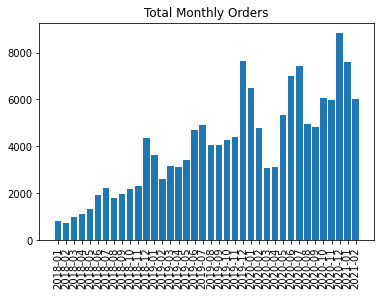

In [5]:
# Plot Monthly Orders
import matplotlib.pyplot as plt
plt.xticks(rotation = "vertical")
plt.title("Total Monthly Orders")
plt.bar(month_dict.keys(), month_dict.values())


From the plot we can immediately see several patterns in the data which could later be exploited in prediction. For instance, we can see that there is a linear tendency in the number of orders per month. There is also a seasonal deviation from that tendency in the months of December and January and in the months of June and July in each year. During the months of March and April 2020 we can see a clear reduction in the number of orders because of the Covid-19 pandemic.

<BarContainer object of 31 artists>

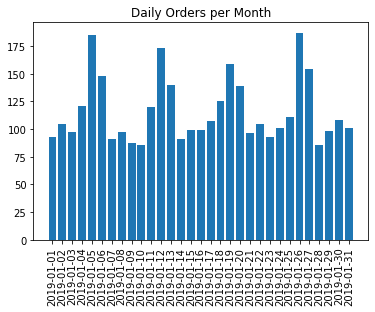

In [6]:
# Plot Daily Orders in a Month
days_in_month = {k: v for k, v in day_dict.items() if k.split("-")[0] == "2019" and k.split("-")[1] == "01"}
plt.xticks(rotation = "vertical")
plt.title("Daily Orders per Month")
plt.bar(days_in_month.keys(), days_in_month.values())

Despite the month we choose to plot, we find that there is a weekly pattern in the number of orders. Meaning that there are some days in the week that consistently receive more orders than the other days. For example, if we choose January 2019 ("2019-01") we see that the days 5, 12, 19, and 26 are higher than the other days in their respective weeks. Followed closely behind 6, 13, 20, and 27 in their respective weeks. Besides the weekly cycle in the number of orders we can see that the process is stationary (by week) and that there is no increase in sales from one week to the next. 

In [7]:
import datetime
datetime.datetime(2019, 1, 5).weekday()

5

From the documentation of datetime we know that the day of the week is returned as an integer, where Monday = 0 and Sunday = 6. So now we know that Saturdays (5) are the day with the highest number of orders followed by Sundays (6).

<BarContainer object of 2 artists>

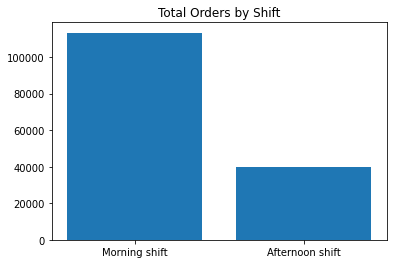

In [8]:
# Orders by Time of Day
plt.title("Total Orders by Shift")
plt.bar(time_dict.keys(), time_dict.values())

### Delivery Option

In [9]:
option = data["DeliveryOption"]
option_dict = {1: 0, 2: 0, 3: 0}
for order in option:
    if "Mismo dia" in order:
        option_dict[1] += 1
    if "Siguiente dia entre 12:30 pm y 2:30 pm" == order:
        option_dict[2] += 1
    if "Siguiente dia entre las 6:30 pm y 8:30 pm" == order:
        option_dict[3] += 1
option_dict

{1: 86800, 2: 45505, 3: 20970}

In [10]:
# Check that all orders have been counted
option.size == sum(option_dict.values())

True

<BarContainer object of 3 artists>

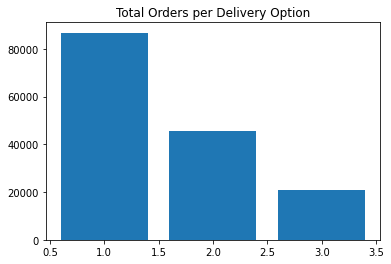

In [11]:
# Plot Delivery Option
plt.title("Total Orders per Delivery Option")
plt.bar(option_dict.keys(), option_dict.values())

In [12]:
# Similarity between Delivery Option and Time of order
print(option_dict)
print(time_dict)

{1: 86800, 2: 45505, 3: 20970}
{'Morning shift': 113281, 'Afternoon shift': 39994}


Since the Type 1 orders can only be processed in the morning and are the most common, we can see that the number of orders in the morning shift is higher than in the afternoon with a ratio of approximately 3:1.

### Covid-19 Affectedness

Since the pandemic had a clear effect on the number of sales in some months, it is important to take into account the level of affectedness as an external variable of the time series before making any predictions

<BarContainer object of 39 artists>

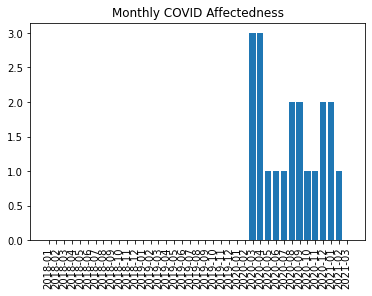

In [14]:
# Level by month
covid_dict = {k: 0 for k in month_dict.keys()}
covid_dict.update({"2020-03": 3,
                   "2020-04": 3,
                   "2020-05": 1,
                   "2020-06": 1,
                   "2020-07": 1,
                   "2020-08": 2,
                   "2020-09": 2,
                   "2020-10": 1,
                   "2020-11": 1,
                   "2020-12": 2,
                   "2021-01": 2,
                   "2021-02": 1,
                   "2021-03": 0})

plt.xticks(rotation = "vertical")
plt.title("Monthly COVID Affectedness")
plt.bar(covid_dict.keys(), covid_dict.values())

## Model

Before diving into the statistics, let's first recap some of the properties of the data and the desired prediction.

*   Monthly we see a linear trend in the data with a couple seasonal variations in the months of June, July, December and January (the months where people are typically on vacation).
*   The Covid-19 pandemic acts as an external variable on the monthly time series, reducing the number of orders each month. The variable is quantified as the level of affectedness with 0 being no effect and 3 being high effect.
*   At lower time resolution we can see that there is a periodic tendency in the number of orders with higher values on the weekends and lower values on weekdays. Other than that, there is no clear daily increase on the number of sales.

With the previous points in mind, I decided that a SARIMAX model would be the best fit for the data because it lets us take into account the seasonal variations and the external variable of the pandemic. As it is required, the prediction of the shifts must be the same for every day of the month meaning that the daily variation is not taken into account but a smaller time resolution (daily) would allow us to take into account the fact that there are more orders during the weekends and allocate more pickers during these days, although it would considerably increase the complexity of the model.



### Grid Search

In [28]:
import itertools
import statsmodels.api as sm
import numpy as np


# We define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# The s is 12 because we have monthly data
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]



In [ ]:
### Run Grid Search ###

# Note: this code will take a while to run

def sarimax_gridsearch(endog, exog, pdq, pdqs, maxiter=50):
    '''
    Input: 
        endog : the time series data of monthly orders
        exog: the time series of the covid affectedness
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(endog, # this is your time series you will input
                                                exog,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)
    ans_df = ans_df[ans_df['bic'] > -np.inf][0:10]
    
    return ans_df
    

endog = list(month_dict.values())
exog = list(covid_dict.values())

sarimax_gridsearch(endog, exog, pdq, pdqs)

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =718.9213928844375
SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =1020.2249110337276


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =455.1255378746477
SARIMAX (0, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =193.64175647853816
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =443.5262802023763


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =407.7146357298497
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =208.60142989037175
SARIMAX (0, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =-18.88970224370759
SARIMAX (0, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =206.84381068121135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =685.3812119242727
SARIMAX (0, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =-39.60335900482234
SARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =680.4596322193465
SARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =2020.8652943884435
SARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =417.6338252255923
SARIMAX (0, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =179.5376288953484


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =424.1539201956952


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =383.8831615324573
SARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =209.21218830403768


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =8.686889782995907


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =236.33146423916557


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =274.1203929723297


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =32.490473825159306
SARIMAX (0, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =645.89830721018
SARIMAX (0, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =2013.6010274940647


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =391.14099428663474
SARIMAX (0, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =167.1357780485296
SARIMAX (0, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =414.44759955213374


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =376.71422045532705


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =217.2195293909967


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =5.718880150851897


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =221.70217095673897


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =280.1192427875314


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:887: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =18.65574917941352
SARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =618.4939873862163
SARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =nan
SARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =366.34760814822096
SARIMAX (0, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =173.5650834306148
SARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =367.6421249505247
SARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =nan


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =184.66615240065963


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =nan
SARIMAX (0, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =187.21830827587564
SARIMAX (0, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =nan


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =nan
SARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =605.3917274134035
SARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =2280.6844818600002
SARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =350.65256111954875
SARIMAX (0, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =160.84758490627655
SARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =370.20549948930557


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =338.0886612935351
SARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =186.08141624812143
SARIMAX (0, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =-13.723443723550693
SARIMAX (0, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =188.62479860307835


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =191.18900047072782
SARIMAX (0, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =7.316134234837122
SARIMAX (0, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =585.3872949251272
SARIMAX (0, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =1938.4963148621391
SARIMAX (0, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =332.20568671232735
SARIMAX (0, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =147.6521807149093
SARIMAX (0, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =373.1866661807304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =329.9440378674569
SARIMAX (0, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =184.24616515842047
SARIMAX (0, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =-1.1297861789791261


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =191.22700648235534


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =189.7013390267549
SARIMAX (0, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =4.475050969193299
SARIMAX (0, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =625.5537622292742
SARIMAX (0, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =367.7269489874267
SARIMAX (0, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =169.77449205830584
SARIMAX (0, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =370.8470784557903
SARIMAX (0, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =182.1334367138865
SARIMAX (0, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =184.5967831064259
SARIMAX (0, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =595.4869110075886
SARIMAX (0, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =343.3470907142221
SARIMAX (0, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =151.41172349311742
SARIMAX (0, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =357.77332450829056


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =176.04150473886975


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =178.4492302130888
SARIMAX (0, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =571.1006121142689
SARIMAX (0, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =330.79083521506493
SARIMAX (0, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =135.94451441085263


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =360.12143724662735


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =171.75754635431952


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (0, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =180.4179626555834
SARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =638.1176846942218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =1038.6596891465929
SARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =387.2729875886982
SARIMAX (1, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =189.2757536986875


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =368.24682664726134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =374.0260561334057


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =200.7703854735147
SARIMAX (1, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =-6.680445757972667


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =249.81419671788515


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =244.80158215452028
SARIMAX (1, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =-5.531505637245505
SARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =637.7659119622717
SARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =2719.8168534738743
SARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =366.97884745898386


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =176.9651069277353


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =451.80228931666926


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =364.84847800701914


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =188.29470253136037
SARIMAX (1, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =28500312229.623405


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =241.41834341689645


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =258.5538952919759


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =12.973581031140766
SARIMAX (1, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =654.780189885851


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =1898.6163895177735
SARIMAX (1, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =350.99225082473566
SARIMAX (1, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =165.41007016428645


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =403.77367955066524


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =368.67752323845946


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =195.41289368812642
SARIMAX (1, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =-6.143245765354478


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =193.91860820564037


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =257.7155999489616


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =14.22003686125317
SARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =622.0531939079724


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =1011.5375603439693
SARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =369.2078538335471
SARIMAX (1, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =175.0628874285118
SARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =346.9771905398893


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =349.87162480060704
SARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =172.70713018387545
SARIMAX (1, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:948: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/eval_measures.py:386: RuntimeWarning: divide by zero encountered in log
  return -2. * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =175.022845959339


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =176.99409888407894
SARIMAX (1, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =-inf
SARIMAX (1, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =606.4195462003987
SARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =63753718.375528574
SARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =351.0806995628295
SARIMAX (1, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =162.15784029591583


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =353.87163286239326


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =340.5240363999813


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =175.58472583851884
SARIMAX (1, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =177.9535258076258


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =179.25981321700982
SARIMAX (1, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =-inf
SARIMAX (1, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =588.4297626176636
SARIMAX (1, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =23221.134994604447
SARIMAX (1, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =334.3835214419443


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =149.14206116717764


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =359.69611955214225


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =331.95727448949424


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =172.3109233376459
SARIMAX (1, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =175.07899546254606


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =183.74678538828906
SARIMAX (1, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =-inf
SARIMAX (1, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =624.9738089511444
SARIMAX (1, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =368.06340316872377
SARIMAX (1, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =166.6191376231067
SARIMAX (1, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =345.92713673546007
SARIMAX (1, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =163.95817992061853


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =166.96470364675457
SARIMAX (1, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =598.8570562312299
SARIMAX (1, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =346.49630024640675
SARIMAX (1, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =152.41864195486443
SARIMAX (1, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =340.49282515504586
SARIMAX (1, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =161.95877129075532


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =171.327561470809
SARIMAX (1, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =580.4254754931294
SARIMAX (1, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =331.93808736587954


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =136.01827729943057


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =347.3731548318021


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =161.9565218563243


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (1, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =164.17964301522034
SARIMAX (2, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =647.3310596180811
SARIMAX (2, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =1516.6587826839352
SARIMAX (2, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =372.2835855990744
SARIMAX (2, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =176.83972844169648


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =437.75877817972764


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =414.7234476972308


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =194.25073215383622
SARIMAX (2, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =218.53154438263607


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =236.74426988201068
SARIMAX (2, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =643.3143170512122
SARIMAX (2, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =1964.2410918305375
SARIMAX (2, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =395.70740536312957


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =179.42306022190328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =417.16159687074827


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =415.3188135633461
SARIMAX (2, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =195.3199366424489
SARIMAX (2, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =213.2349900753976


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =228.7601278400055
SARIMAX (2, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =-inf
SARIMAX (2, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =656.8741414780238
SARIMAX (2, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =1934.9339693479685


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =374.2777135667388


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =163.90804974603708
SARIMAX (2, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =461.99755367824184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =394.5395007223977


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =200.9820719655771
SARIMAX (2, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =-inf


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =229.5839051737102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =248.62340456799168
SARIMAX (2, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =-inf
SARIMAX (2, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =603.7112949673162


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =1263.707813954744
SARIMAX (2, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =354.4480299066755
SARIMAX (2, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =163.0480869107248
SARIMAX (2, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =336.5831016489512


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =339.70869667944066
SARIMAX (2, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =161.1435864162606
SARIMAX (2, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =nan


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/eval_measures.py:386: RuntimeWarning: invalid value encountered in log
  return -2. * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =163.9226693740322


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =171.61962776666505
SARIMAX (2, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =nan
SARIMAX (2, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =604.78656628067
SARIMAX (2, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =2068.6274131309583
SARIMAX (2, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =350.10109744313036


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =165.04989775188392


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =339.5607218075328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =350.345612027936


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =163.2616669014679
SARIMAX (2, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =nan


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =174.3036991210236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =179.03147000755575
SARIMAX (2, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =nan
SARIMAX (2, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =577.9683750991989


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =1880.2127910974305
SARIMAX (2, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =337.4723439348801


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =151.5888710188288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =351.1585217634949


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =339.90588279023564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =160.5541739034645
SARIMAX (2, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =nan


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =177.07678754499693


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =181.75291282480467
SARIMAX (2, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =nan
SARIMAX (2, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =600.3931093098533
SARIMAX (2, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =349.99383433782214
SARIMAX (2, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =152.15965443162523
SARIMAX (2, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =329.30848811207227
SARIMAX (2, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =146.3527147838617


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =149.2514368507803
SARIMAX (2, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =588.8835902725252
SARIMAX (2, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =346.6586945305434
SARIMAX (2, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =153.2651616240521


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =327.7405331422218
SARIMAX (2, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =147.64368081542418


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =154.4498021102466
SARIMAX (2, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =576.6448545080608


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =333.59859280685794


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =136.469689412442


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =339.0356645718572


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMAX (2, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =146.11027959458312
SARIMAX (2, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =153.9203231352979


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,pdq,pdqs,bic
10,"(0, 0, 0)","(2, 1, 0, 12)",-39.603359
7,"(0, 0, 0)","(1, 2, 0, 12)",-18.889702
51,"(0, 1, 1)","(1, 2, 0, 12)",-13.723444
91,"(1, 0, 0)","(1, 2, 0, 12)",-6.680446
113,"(1, 0, 2)","(1, 2, 0, 12)",-6.143246
94,"(1, 0, 0)","(2, 1, 0, 12)",-5.531506
62,"(0, 1, 2)","(1, 2, 0, 12)",-1.129786
65,"(0, 1, 2)","(2, 1, 0, 12)",4.475051
29,"(0, 0, 2)","(1, 2, 0, 12)",5.718880
54,"(0, 1, 1)","(2, 1, 0, 12)",7.316134


### Prediction

In [80]:
endog = list(month_dict.values())
exog = list(covid_dict.values())[:-1]
# df = pd.DataFrame.from_dict(month_dict, orient= "index", columns =["Orders"])
model = sm.tsa.statespace.SARIMAX(endog, 
                                  exog,
                                  order=(0,1,1),
                                  seasonal_order=(1,2,0,12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
                                    
# Fit the model
output = model.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
# output.plot_diagnostics(figsize=(16,10));

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(1, 2, 0, 12)   Log Likelihood                   6.862
Date:                            Wed, 24 Mar 2021   AIC                             -5.723
Time:                                    16:05:33   BIC                            -13.723
Sample:                                         0   HQIC                              -inf
                                             - 38                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -931.2209   3.48e-10  -2.68e+12      0.000    -931.221    -931.221
ma.L1          0.0152   1.29e-15   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2220: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/eval_measures.py:411: RuntimeWarning: divide by zero encountered in log
  return -2. * llf + 2 * np.log(np.log(nobs)) * df_modelwc


<BarContainer object of 38 artists>

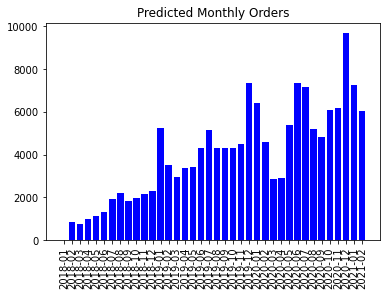

In [81]:
prediction = output.predict(start = 0,exog=exog, dynamic=False)
plt.xticks(rotation = "vertical")
plt.title("Predicted Monthly Orders")
plt.bar(month_dict.keys(), prediction, color='b',align='center')

<BarContainer object of 38 artists>

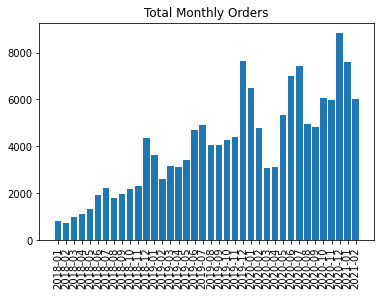

In [82]:
plt.xticks(rotation = "vertical")
plt.title("Total Monthly Orders")
plt.bar(month_dict.keys(), month_dict.values())

The MSE is 285759.605163979
The RMSE is 534.5648746073567


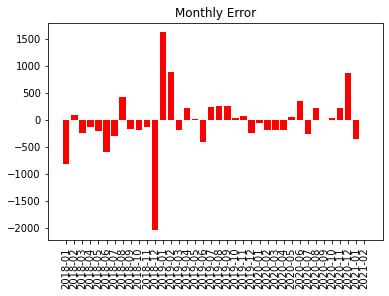

In [86]:
error = prediction-list(month_dict.values())
plt.xticks(rotation = "vertical")
plt.title("Monthly Error")
plt.bar(month_dict.keys(), error, color='r')
mse = (error ** 2).mean()
rmse = np.sqrt(mse)
print("The MSE is "+str(mse))
print("The RMSE is "+str(rmse))

In [112]:
pred_march = output.predict(start = len(month_dict.values()),exog=[[0]], dynamic=False)
pred_march = int(pred_march)
print("The expected number of orders in the month of March 2021 is "+str(pred_march))

The expected number of orders in the month of March 2021 is 8365


Finally, we get a prediction of 8365 orders in the month of March 2021. Now, we have to convert this into the number of pickers we need each day. For this we will not consider the daily variation in the number of orders (as stated before) and we will simply divide by the number of days to get the daily orders

In [114]:
daily_orders = pred_march/31
daily_orders = round(daily_orders)
daily_orders

270

Now, we know that the orders are approximately dristibuted with a ratio of 3:1 between the morning and the afternoon so we get:

In [116]:
# Orders per shift
morning = daily_orders*0.75
afternoon = daily_orders*0.25
print("The morning shift will get "+str(morning)+" orders")
print("The afternoon shift will get "+str(afternoon)+" orders")


The morning shift will get 202.5 orders
The afternoon shift will get 67.5 orders


We also know that every worker picks at least 5 orders per hour and each shift lasts 6 hours

In [119]:
# Number of pickers
import math
morning_pickers = math.ceil(morning/(5*6))
afternoon_pickers = math.ceil(afternoon/(5*6))
print("The morning shift will need "+str(morning_pickers)+" pickers")
print("The afternoon shift will need "+str(afternoon_pickers)+" pickers")

The morning shift will need 7 pickers
The afternoon shift will need 3 pickers


## Conclusion

*   The SARIMAX model predicted a number of orders in March of 8365 assuming an affectedness of 0. This is consistent with the visualized growth in the number of orders.
*   Despite the consistency of the result and the grid search that was done, we can see that the model still has a high RMS error and further tuning of the parameters could improve the results, especially if the model is to be used for forecasting of more than one time step into the future. 
*   The model could be optimized further if the daily variations of the orders are considered because during the weekends the number of orders is higher than during the week, indicating that more pickers are required in some days than others.